In [1]:
from utils import *
from opt import *
import pandas as pd
import numpy as np
from sklearn.covariance import graphical_lasso
import time



In [2]:
def get_params(dn,model):
    aux = 1e-5
    if dn == 'school':
        mu1, eta, mu2 =  1e-6, 1e-6, aux
    elif dn == 'schoolCs4':
        if model == 'GL':
            mu1, eta, mu2 =  0.023357214690901212, 0.0003511191734215131, aux
        elif model == 'GSR':
            mu1, eta, mu2 =  7.405684692262442,  0.005994842503189409, aux
        elif model == 'GLASSO':
            mu1, eta, mu2 =  0.029470517025518096,  0, aux
    elif dn == 'contact311Cs4':
        if model == 'GL':
            mu1, eta, mu2 = 1e-3, 1e-3, aux
        elif model == 'GSR':
            mu1, eta, mu2 =  0.01,  0.06, aux
        elif model == 'GLASSO':
            mu1, eta, mu2 =  0.1,  0, aux
    elif dn == 'movielens':
        if model == 'GL':
            mu1, eta, mu2 =  0.1, 0.001, aux
        elif model == 'GSR':
            mu1, eta, mu2 =  1e4,  1e-5, aux
        elif model == 'GLASSO':
            mu1, eta, mu2 =  0.1,  0, aux
    elif dn == 'coautorship130':
        if model == 'GL':
            mu1, eta, mu2 =  0.005298316906283713,  7.017038286703837e-05, aux
        elif model == 'GSR':
            mu1, eta, mu2 =  8.531678524172814e-06,  1, aux
        elif model == 'GLASSO':
            mu1, eta, mu2 =  0.01,  0, aux
    else:
        print('Unknown dataset')
    return mu1, mu2, eta


def estimate_Theta(C_hat, Z, mu1, mu2, eta, model):
    if model == 'GLASSO':
        _, Theta_hat = graphical_lasso(C_hat, alpha=mu1, max_iter=1000, tol=1e-6) 
    elif model == 'FGLASSO_mu20':
        Theta_hat = FairGLASSO_fista(C_hat, mu1, eta, 0, Z, bias_type='dp',
                                        epsilon=0.1, iters=1000, EARLY_STOP=False, prec_type=None) 
    elif model == 'FGLASSO_dp':
        Theta_hat = FairGLASSO_fista(C_hat, mu1, eta, mu2, Z, bias_type='dp',
                                        epsilon=0.1, iters=1000,EARLY_STOP=False, prec_type=None)
    elif model == 'FGLASSO_nw':
        Theta_hat = FairGLASSO_fista(C_hat, mu1, eta, mu2, Z, bias_type='nodewise',
                                        epsilon=0.1, iters=1000,EARLY_STOP=False, prec_type=None)
    elif model == 'FGSR_dp':
        Theta_hat = FairGSR_fista(C_hat, mu1, eta, mu2, Z, bias_type='dp', iters=1000,
                     prec_type='non-negative', tol=1e-3, EARLY_STOP=False, RETURN_ITERS=False)
    elif model == 'FGSR_nw':
        Theta_hat = FairGSR_fista(C_hat, mu1, eta, mu2, Z, bias_type='nodewise', iters=1000,
                     prec_type='non-negative', tol=1e-3, EARLY_STOP=False, RETURN_ITERS=False)
    elif model == 'FGLASSO_cvx_dp':
        Theta_hat = FairGLASSO_cvx(C_hat, Z, mu1, mu2, epsilon=.1, bias_type='dp') 
    elif model == 'FGLASSO_cvx_nw':
        Theta_hat = FairGLASSO_cvx(C_hat, Z, mu1, mu2, epsilon=.1, bias_type='nodewise') 
    else:
        print('Unknown opt model')
    return Theta_hat

dnames = ['schoolCs4', 'coautorship130', 'movielens','contact311Cs4']
models = ['GLASSO','FGLASSO_mu20','FGLASSO_dp','FGLASSO_nw','FGSR_dp','FGSR_nw']
mdl = ['GL','GL','GL','GL','GSR','GSR']
mus2 = np.logspace(0,6,7)

nd = len(dnames)
nm = len(mus2)
nmdl = len(models)
nmetrics = 5 # use 5 metrics for measuring bias 

est_error = np.zeros((nd, nmdl, nm))
est_fsc = np.zeros((nd, nmdl, nm))
est_bias = np.zeros((nd, nmdl, nm, nmetrics)) 
est_bias_bin = np.zeros((nd, nmdl, nm, nmetrics)) 
model_fit = np.zeros((nd, nmdl, nm))
all_times = np.zeros((nd, nmdl, nm))
true_bias = np.zeros((nd, nmetrics))
true_model_fit = np.zeros((nd,1))
All_A_hat = {}
All_A_hat_bin = {}

for k, dn in enumerate(dnames):
    A_true, A_true_bin, C_est, C_est_norm, Z, z = load_datasets(dn)
    N = A_true.shape[0]
    C_hat = C_est_norm
    true_bias[k,:] = compute_all_bias(A_true,Z)
    true_model_fit[k] = np.linalg.norm(A_true @ C_hat - np.eye(N), 'fro')/np.linalg.norm(C_hat, 'fro')
    d_A_hat = np.zeros((nd, nmdl, nm,N,N))
    d_A_hat_bin = np.zeros((nd, nmdl, nm,N,N))
    for i, mu2 in enumerate(mus2):
        for m, model in enumerate(models):
            mu1, m2, eta = get_params(dn,mdl[m])
            start_time = time.time()
            Theta_hat = estimate_Theta(C_hat, Z, mu1, mu2, eta, model)
            Theta_hat_norm = Theta_hat/np.max(Theta_hat)
            end_time = time.time()
            elapsed_time = end_time - start_time
            all_times[k,m,i] = elapsed_time
            model_fit[k,m,i] = np.linalg.norm(Theta_hat_norm @ C_hat - np.eye(N), 'fro')/np.linalg.norm(C_hat, 'fro')
            A_hat, A_hat_bin = extract_estimation(Theta_hat, A_true_bin)
            d_A_hat[k,m,i,:,:] = A_hat
            d_A_hat_bin[k,m,i,:,:] = A_hat_bin
            est_error[k,m,i] = compute_frob_err(A_hat, A_true)
            est_fsc[k,m,i] = compute_f1_score(A_hat_bin, A_true_bin)
            est_bias[k,m,i,:] = compute_all_bias(A_hat,Z)
            est_bias_bin[k,m,i,:] = compute_all_bias(A_hat_bin,Z)
    All_A_hat[dnames[k]] = d_A_hat
    All_A_hat_bin[dnames[k]] = d_A_hat_bin



c:\Users\Andrei\OneDrive - Universidad Rey Juan Carlos\Doctorado\papers\fair_neurips\last_version\fair_GL-main\opt.py:117: RuntimeWarning: overflow encountered in multiply
  Gradient = Sigma - la.inv( Theta + epsilon*np.eye(p) ) + mu2*fairness_term
C:\Users\Andrei\AppData\Roaming\Python\Python39\site-packages\sklearn\covariance\_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 1.547e-03
  warnings.warn(
C:\Users\Andrei\AppData\Roaming\Python\Python39\site-packages\sklearn\covariance\_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 1.547e-03
  warnings.warn(
C:\Users\Andrei\AppData\Roaming\Python\Python39\site-packages\sklearn\covariance\_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 1.547e-03
  warnings.warn(
C:\Users\Andrei\AppData\Roaming\Python\Python39\site-packages\sklearn\covariance\_graph_lasso.py:184: Conv

In [3]:
#save # Create a dictionary to store all your variables
import pickle
workspace = {
    'All_A_hat': All_A_hat,
    'All_A_hat_bin': All_A_hat_bin,
    'est_error': est_error,
    'est_fsc': est_fsc,
    'est_bias': est_bias,
    'est_bias_bin': est_bias_bin,
    'model_fit': model_fit,
    'true_bias': true_bias,
    'models': models,
    'dnames': dnames,
    'mus2': mus2,
    'all_times': all_times,
    'true_model_fit':true_model_fit
}

# Save the workspace to a file
with open('workspace_v1.pkl', 'wb') as file:
    pickle.dump(workspace, file)





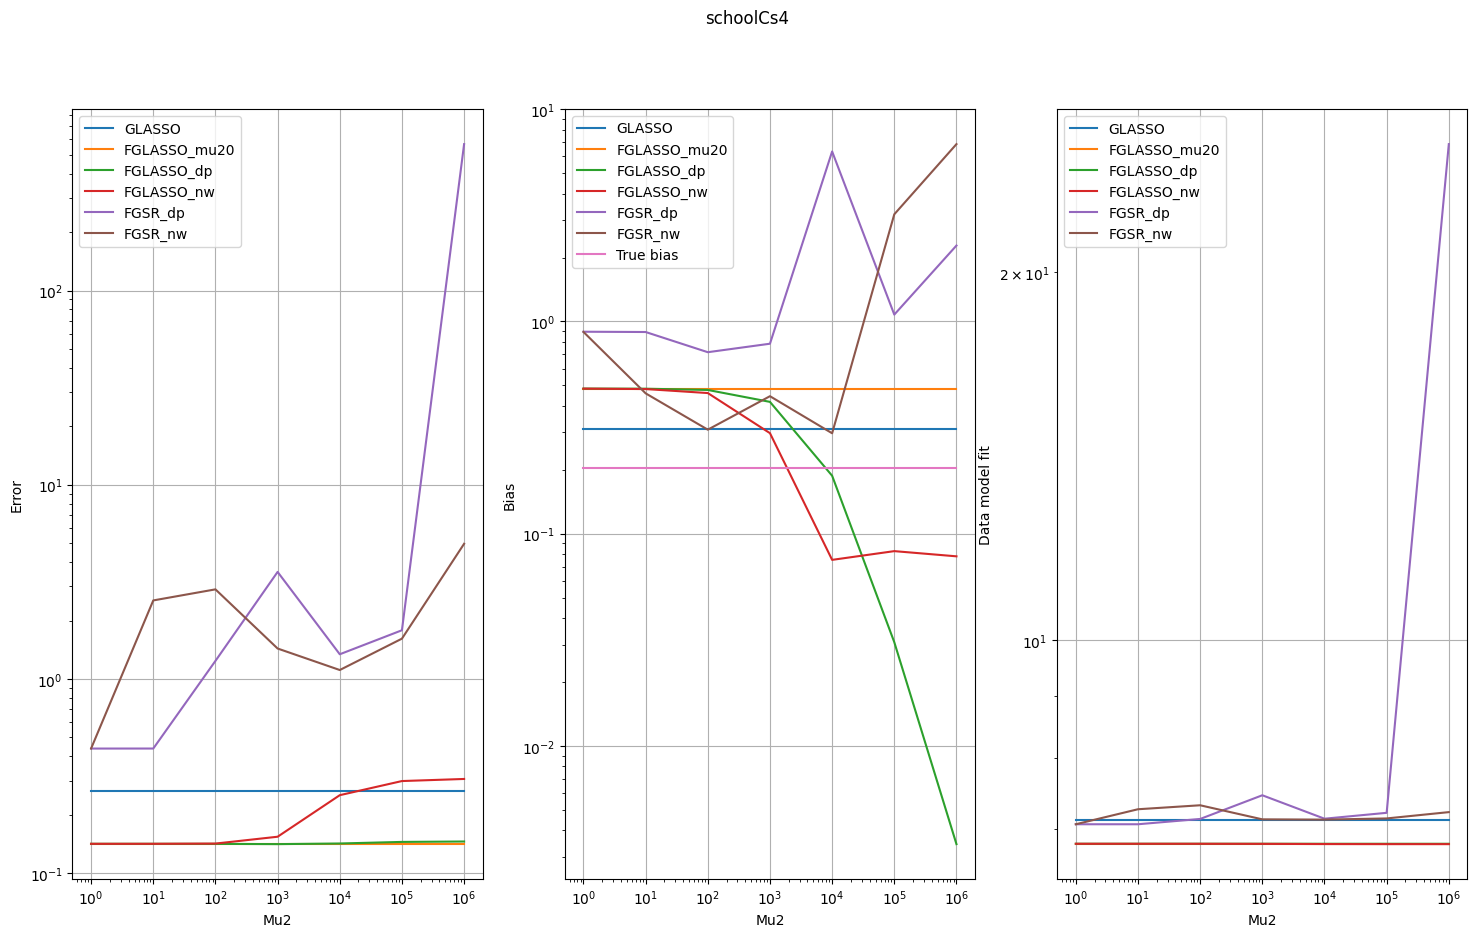

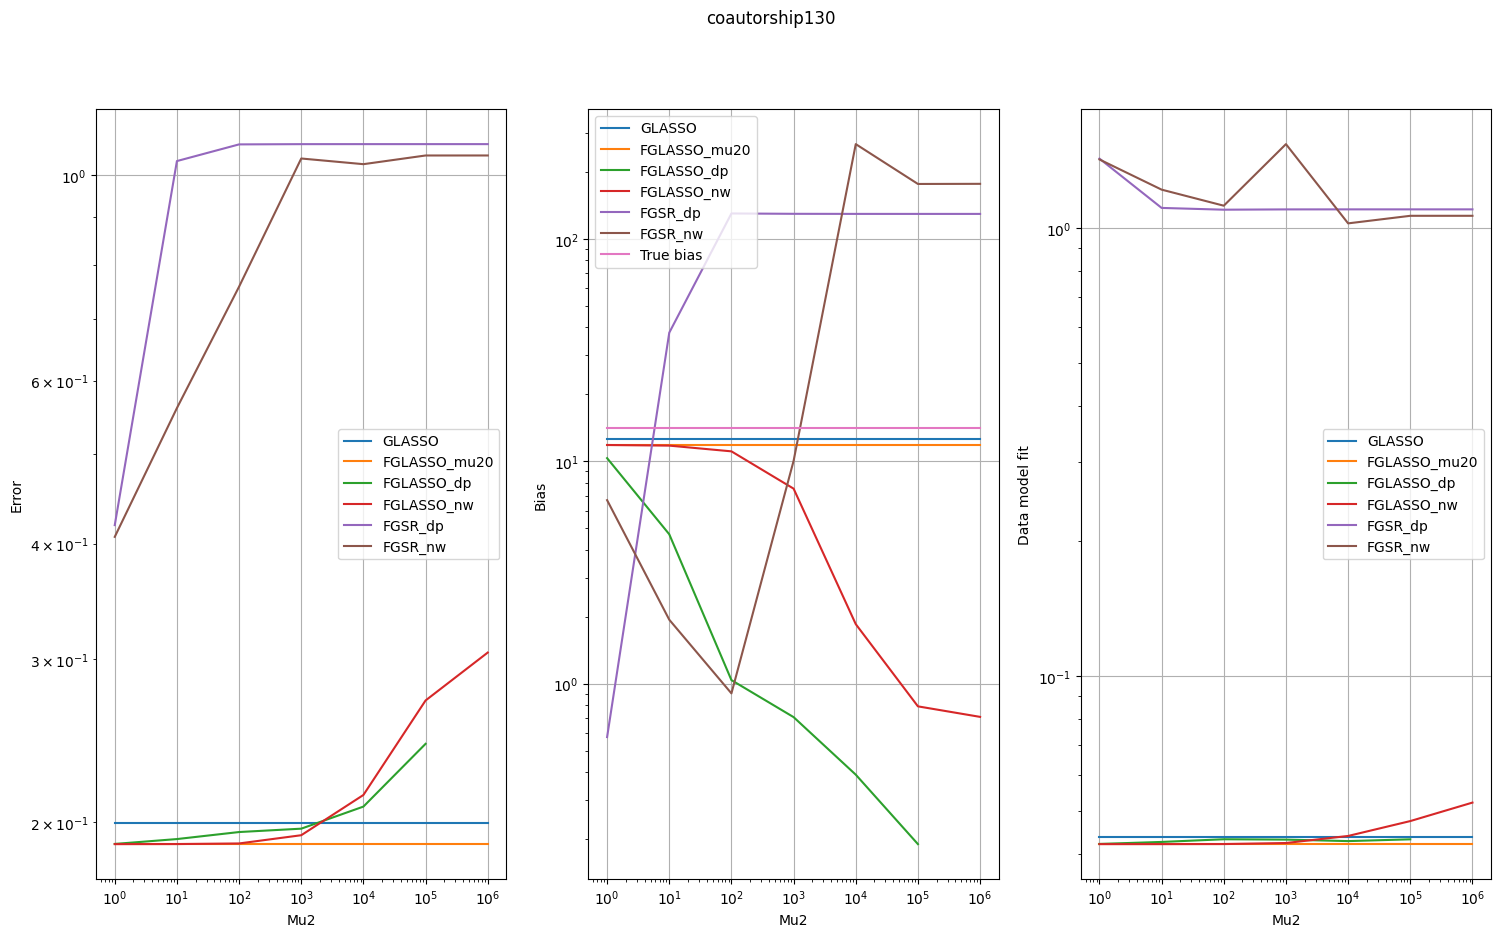

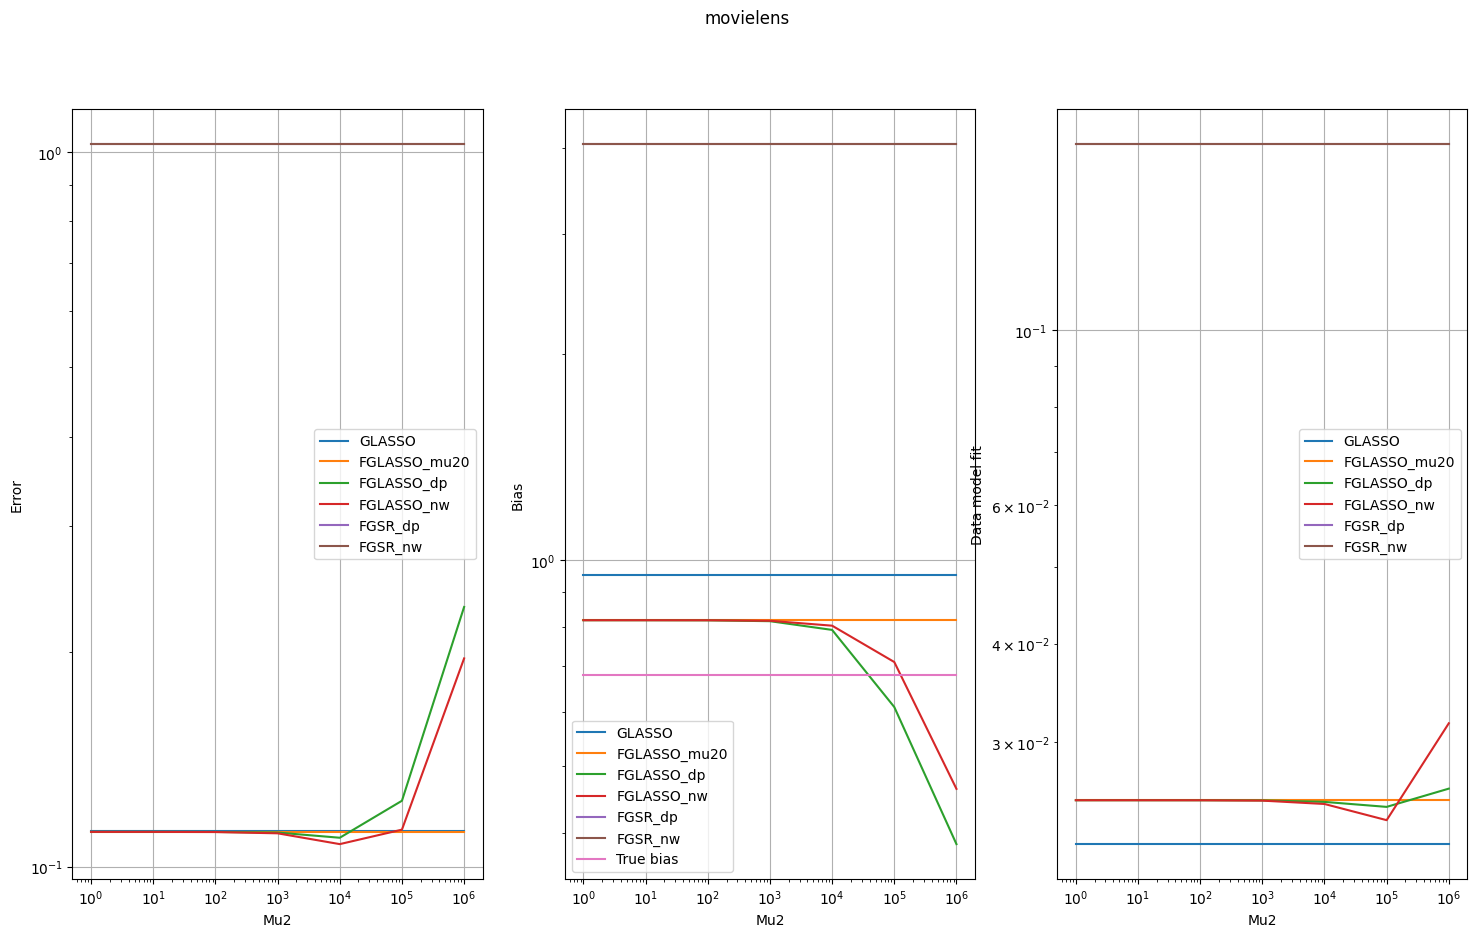

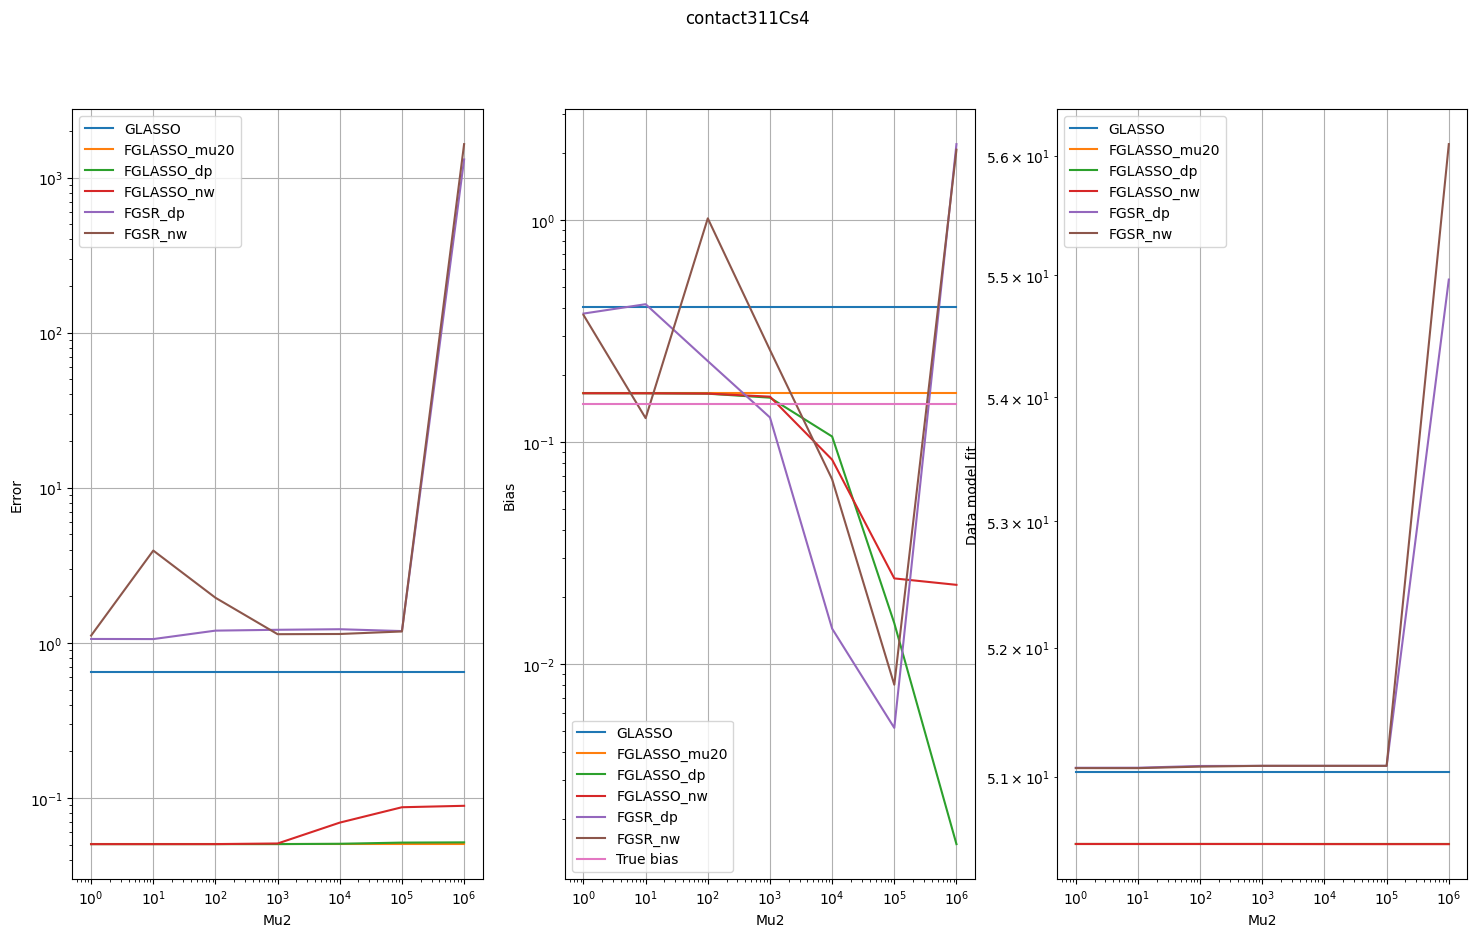

In [5]:
plt.rcParams["figure.figsize"] = (18, 10)

t_b = np.array(['True bias'])
lgnd = np.concatenate((models,t_b))
for k, dn in enumerate(dnames):
    plt.figure()
    plt.subplot(131)
    plt.loglog(mus2, est_error[k,:,:].T)
    plt.xlabel('Mu2')
    plt.ylabel('Error')
    plt.grid()
    plt.legend(models)
    plt.subplot(132)
    plt.loglog(mus2, est_bias[k,:,:,4].T)
    plt.loglog(mus2,true_bias[k,4]*np.ones((7,1)))
    plt.xlabel('Mu2')
    plt.ylabel('Bias')
    plt.grid()
    plt.legend(lgnd)
    plt.subplot(133)
    plt.loglog(mus2,model_fit[k,:,:].T)
    plt.xlabel('Mu2')
    plt.ylabel('Data model fit')
    plt.grid()
    plt.legend(lgnd)
    plt.suptitle(dn)


In [ ]:
for k, dn in enumerate(dnames):
    plt.figure()
    plt.subplot(121)
    plt.loglog(mus2, est_error[k,:,:].T)
    plt.xlabel('Mu2')
    plt.ylabel('Error')
    plt.legend(models)

    plt.subplot(122)
    plt.semilogx(mus2, est_fsc[k,:,:].T)
    plt.xlabel('Mu2')
    plt.ylabel('Fscore')
    plt.legend(models)
    plt.title(dn)


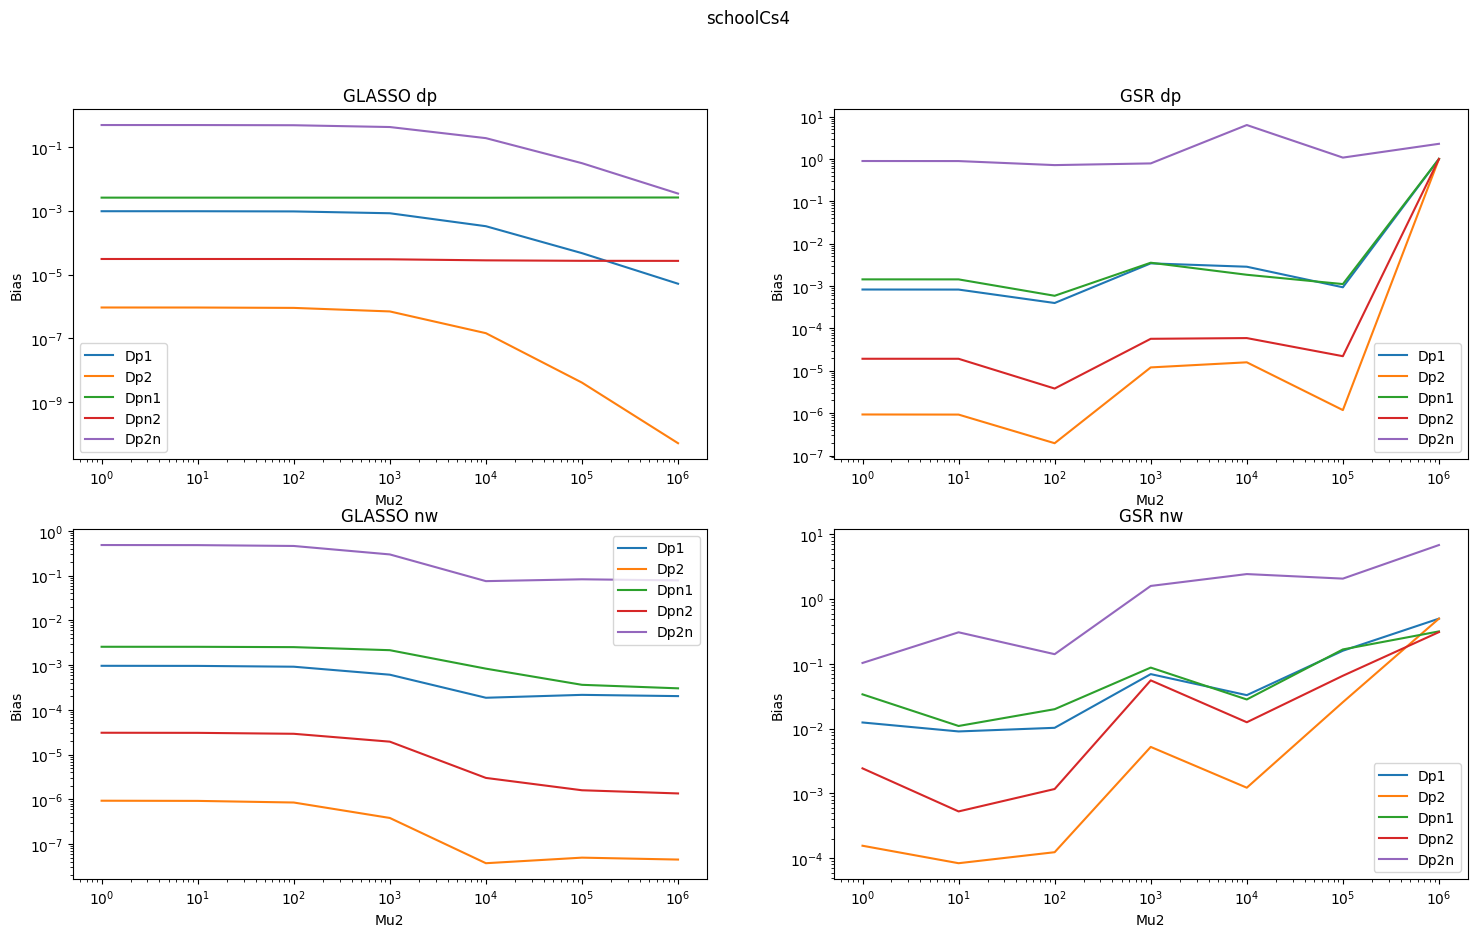

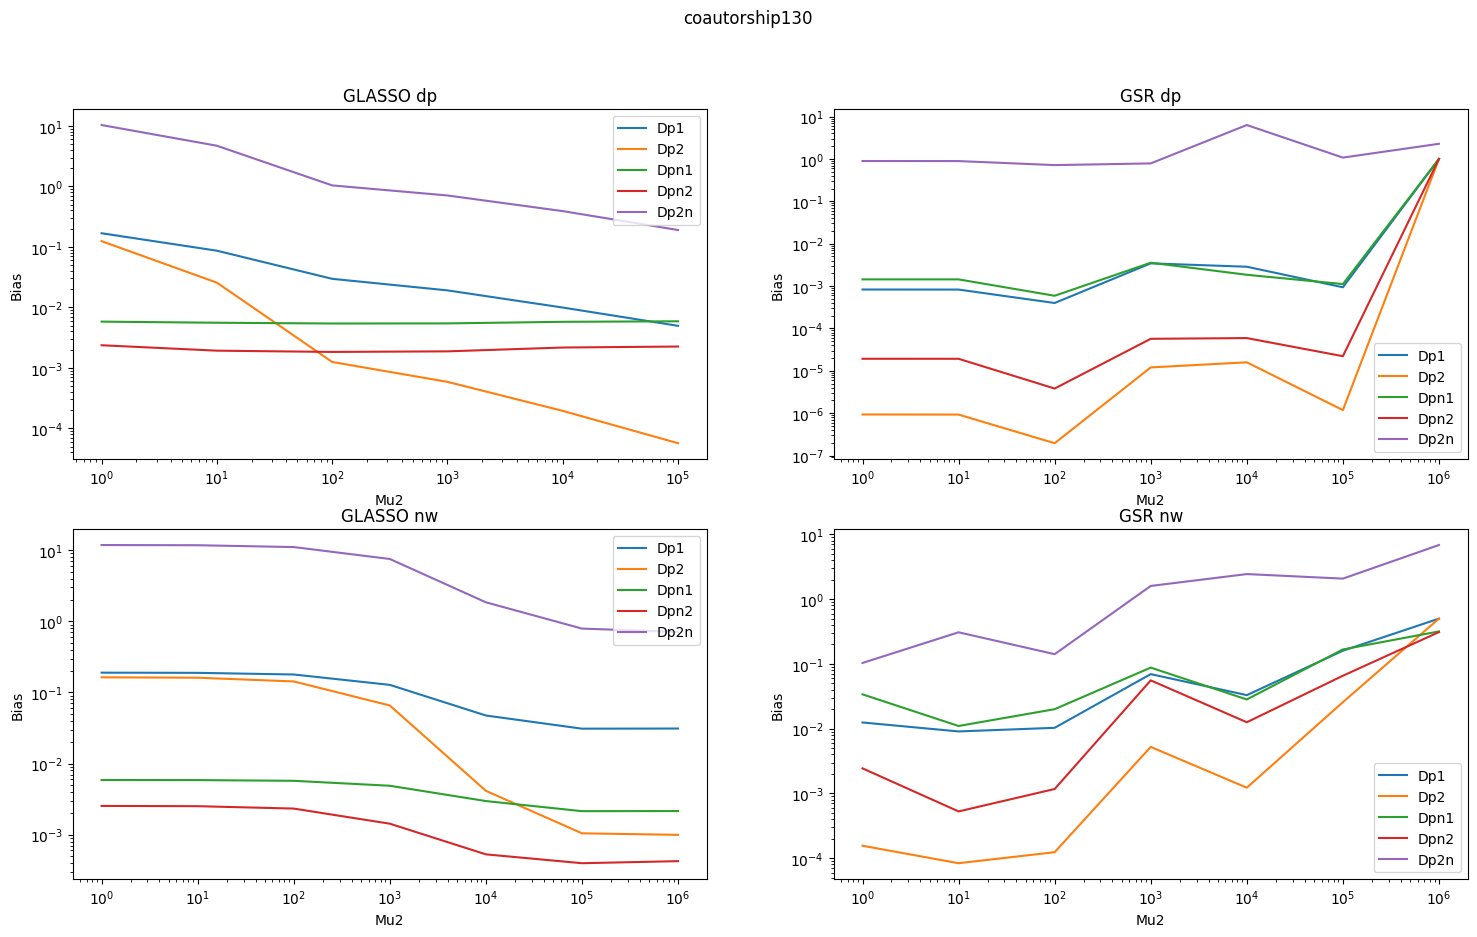

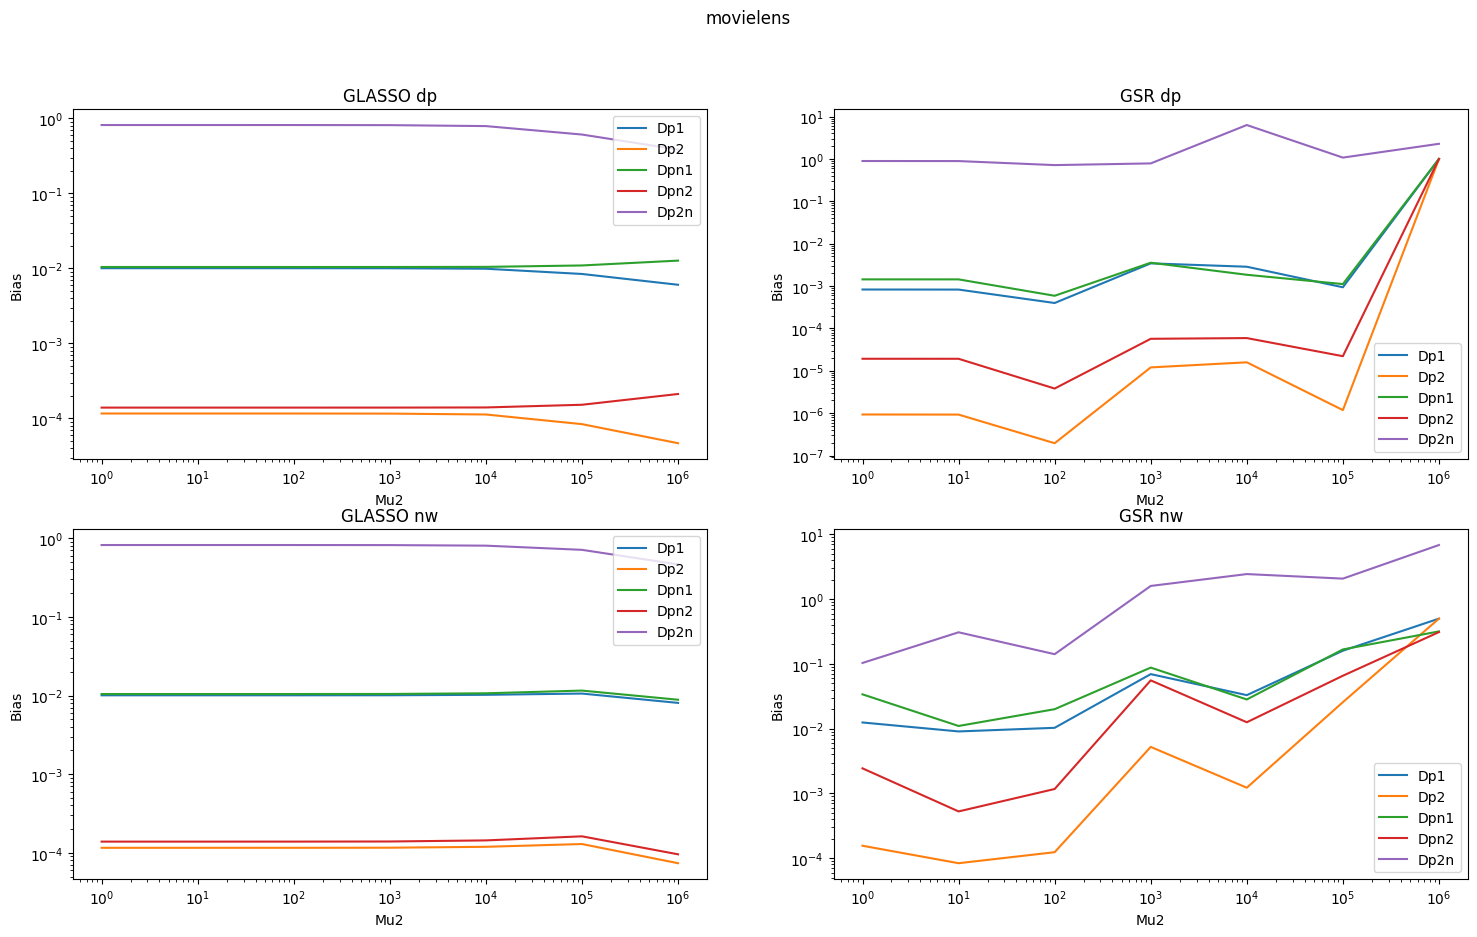

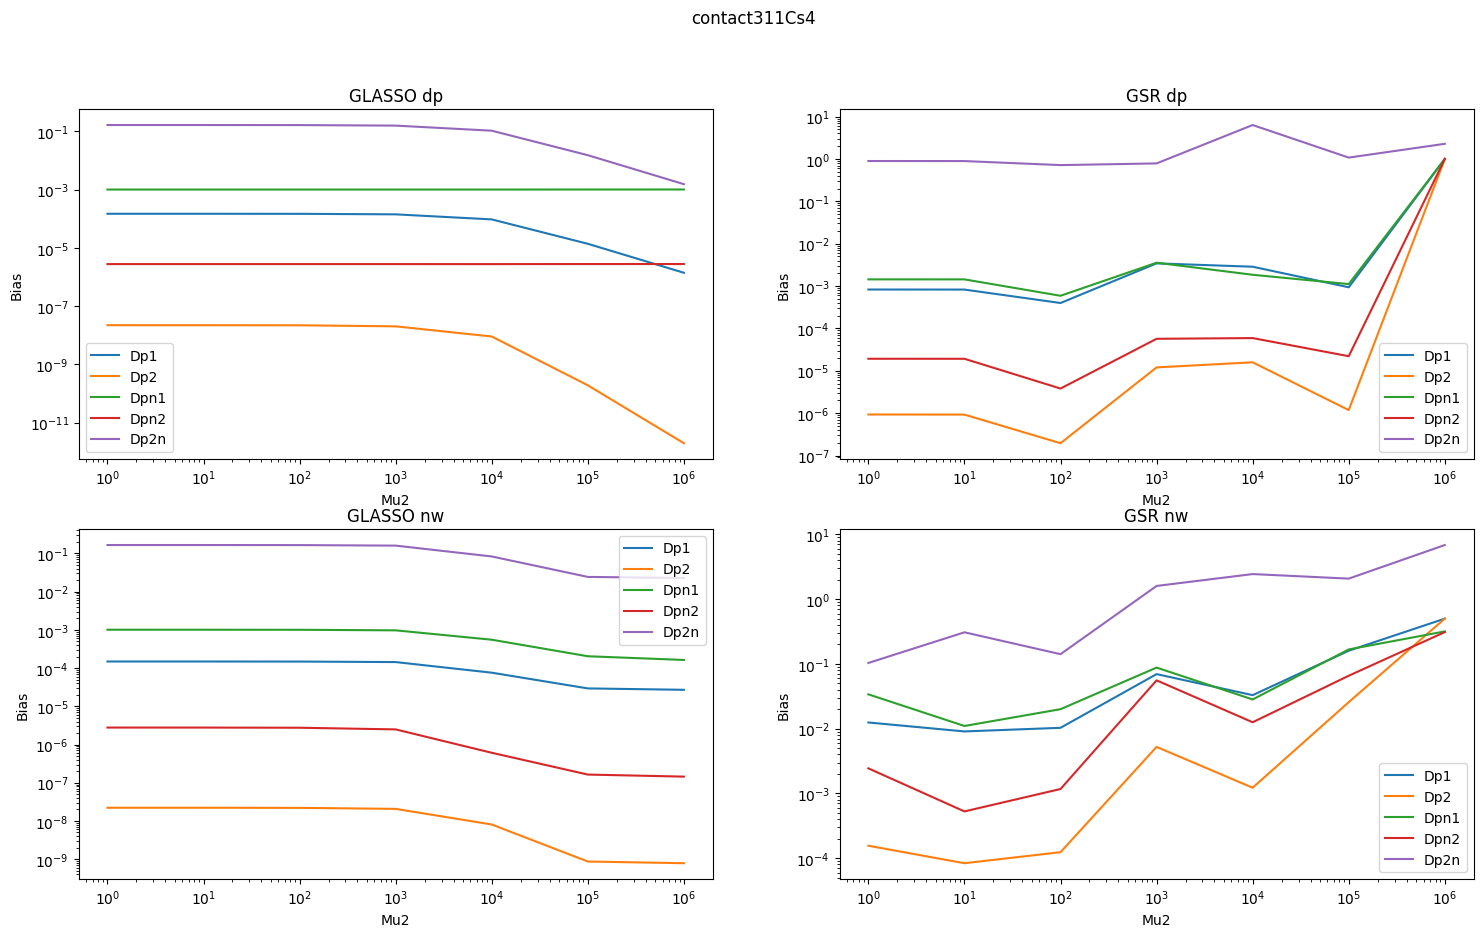

In [6]:
metrics = ['Dp1','Dp2','Dpn1','Dpn2','Dp2n']

for k, dn in enumerate(dnames):
    plt.figure()
    plt.subplot(221)
    plt.loglog(mus2, est_bias[k,2,:,:]) #[dataset,model,mus,biasmetric]
    plt.xlabel('Mu2')
    plt.ylabel('Bias')
    plt.legend(metrics)
    plt.title('GLASSO dp')
    plt.subplot(222)
    plt.loglog(mus2, est_bias[0,4,:,:])
    plt.xlabel('Mu2')
    plt.ylabel('Bias')
    plt.legend(metrics)
    plt.title('GSR dp')
    plt.subplot(223)
    plt.loglog(mus2, est_bias[k,3,:,:]) #[dataset,model,mus,biasmetric]
    plt.xlabel('Mu2')
    plt.ylabel('Bias')
    plt.legend(metrics)
    plt.title('GLASSO nw')
    plt.subplot(224)
    plt.loglog(mus2, est_bias_bin[0,5,:,:])
    plt.xlabel('Mu2')
    plt.ylabel('Bias')
    plt.legend(metrics)
    plt.title('GSR nw')
    plt.suptitle(dn)
